#**VOICE CONVERSION (ML PROJECT PHASE 2) - GROUP 30 - PART_1 - TESTING**

##**PIPELINE**

1 TO 1 VOICE CONVERSION

1. FEATURE EXTRACTION :
2. FEATURE ALLIGNMENT :
3. CONVERSION :
4. EVALUATION :
5. FINE-TUNING & VALIDATION :

ELABOURATING THE STEPS

1. Feature Extraction:
Extract Source and Target Features: Use techniques like MFCCs, spectral features, or any other relevant feature representation from the source and target speech data.
Preprocess Features: Normalize, scale, or preprocess the extracted features to make them suitable for the learning algorithm.
2. Feature Alignment:
Align Source and Target Features: Perform alignment between the source and target feature representations. This could involve dynamic time warping (DTW) or other alignment techniques to synchronize corresponding features.
3. Conversion:
Train Conversion Model: Utilize a chosen classical ML technique (like GMM, HMM, neural networks, etc.) to learn the mapping between aligned source and target features.
Apply Conversion: Use the trained model to convert the source features to sound like the target speaker.
4. Evaluation:
Objective Evaluation: Use metrics like Mean Squared Error (MSE), Perceptual Evaluation of Speech Quality (PESQ), or other relevant metrics to evaluate the quality of the converted speech.
Subjective Evaluation: Conduct subjective tests where human listeners assess the converted speech quality for naturalness, similarity to the target, etc.
5. Fine-tuning & Validation:
Fine-tune Model: Adjust parameters, perform feature engineering, or consider ensemble methods to improve the conversion quality.
Validation: Validate the performance of the fine-tuned model using separate validation datasets and ensure it generalizes well beyond the training data.
This pipeline outlines the steps involved in converting the voice from a source speaker to sound like a specific target speaker using classical ML methods. Each step involves careful consideration of algorithms, feature representations, and evaluation techniques to achieve high-quality voice conversion.

##**SETTING UP THE SYSTEM**

In [ ]:
!pip install pydub

In [ ]:
!pip install nnmnkwii

In [ ]:
!pip install fastdtw

In [ ]:
import os
import string
import librosa
import librosa.display

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from google.colab import drive

from sklearn.preprocessing import LabelEncoder
from sklearn.mixture import GaussianMixture
from pydub import AudioSegment

from IPython.display import Audio

from scipy.spatial.distance import cdist
from scipy.spatial.distance import squareform
from scipy.spatial.distance import euclidean
from scipy import signal
from scipy.signal import medfilt
from scipy.stats import multivariate_normal

from nnmnkwii.preprocessing.alignment import DTWAligner
from nnmnkwii.preprocessing import trim_zeros_frames, remove_zeros_frames, delta_features
from nnmnkwii.util import apply_each2d_trim
from nnmnkwii.metrics import melcd
from nnmnkwii.baseline.gmm import MLPG

from fastdtw import fastdtw

In [ ]:
# Mounting the drive and getting the data
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


##**GETTING THE AUDIO FILES**

In [ ]:
source_audio_location = "/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/"
target_audio_location = "/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/"

In [ ]:
# Initialize an empty list to store file paths
audio_files_source = []

# Walk through the directory and collect file paths
for root, dirs, files in os.walk(source_audio_location):
    for file in files:
        if file.endswith(".wav"):  # Adjust the extension if the audio files have a different format
            file_path = os.path.join(root, file)
            audio_files_source.append(file_path)

# Sort the list of audio file locations alphabetically
audio_files_source_sorted = sorted(audio_files_source)

# Print the list of audio file locations
for file_path in audio_files_source_sorted:
    print(file_path)

/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/sentence_0.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/sentence_1.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/sentence_10.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/sentence_11.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/sentence_12.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/sentence_13.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/sentence_14.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/sentence_15.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/sentence_16.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/sentence_17.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/sentence_18.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/sentence_19.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c1/sentence_2.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/

In [ ]:
# Initialize an empty list to store file paths
audio_files_target = []

# Walk through the directory and collect file paths
for root, dirs, files in os.walk(target_audio_location):
    for file in files:
        if file.endswith(".wav"):  # Adjust the extension if the audio files have a different format
            file_path = os.path.join(root, file)
            audio_files_target.append(file_path)

# Sort the list of audio file locations alphabetically
audio_files_target_sorted = sorted(audio_files_target)

# Print the list of audio file locations
for file_path in audio_files_target_sorted:
    print(file_path)

/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/sentence_0.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/sentence_1.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/sentence_10.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/sentence_11.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/sentence_12.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/sentence_13.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/sentence_14.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/sentence_15.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/sentence_16.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/sentence_17.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/sentence_18.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/sentence_19.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/c2/sentence_2.wav
/content/drive/MyDrive/ML_PROJECT/PHASE_2/Audio_Files/

##**FEATURE EXTRACTION**

###**FEATURE EXTRACTION - SPECTOGRAM**

In [ ]:
def extractSpectogram(audio_file):
  # Load the audio file
  audio, sr = librosa.load(audio_file, sr=None)

  # Compute the spectrogram
  spectrogram = librosa.amplitude_to_db(np.abs(librosa.stft(audio)), ref=np.max)

  # Calculate audio duration
  audio_duration = len(audio) / sr

  # Print data
  # print("Audio duration: ", audio_duration)

  # Display the audio player
  # display(Audio(data=audio, rate=sr))

  # Plot the spectrogram for the the pre-emphasized waveform
  # plt.figure(figsize=(10, 6))
  # librosa.display.specshow(spectrogram, sr=sr, x_axis='time', y_axis='log')
  # plt.colorbar(format='%+2.0f dB')
  # plt.title('Spectrogram')

  return spectrogram

In [ ]:
def reconstruct_audio_griffinlim(spectrogram):
  # Reconstruct the audio from the spectrogram
  y_reconstructed = librosa.griffinlim(librosa.db_to_amplitude(spectrogram))
  return y_reconstructed

In [ ]:
def reconstruct_audio_istft(spectrogram):
  # Reconstruct the audio from the spectrogram
  y_reconstructed = librosa.istft(librosa.db_to_amplitude(spectrogram))
  return y_reconstructed

###**FEATURE EXTRACTION - MFCC**

In [ ]:
def extractMfcc(audio_file):
    # Load an audio file
    audio, sr = librosa.load(audio_file, sr=None)
    # Calculate audio duration
    audio_duration = len(audio) / sr

    # Extract MFCC features
    n_mfcc = 13
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc)

    # Print data
    # print("Audio duration: ", audio_duration)

    # Display the audio player
    # display(Audio(data=audio, rate=sr))

    # Plot MFCCs
    # plt.figure(figsize=(8, 6))
    # librosa.display.specshow(mfcc, x_axis='time', cmap='viridis')
    # plt.colorbar(format='%+2.0f dB')
    # plt.title('MFCCs')
    # plt.show()

    return mfcc

In [ ]:
def reconstruct_audio_imfcc(mfcc):
  # Reconstruct the audio from the spectrogram
  y_reconstructed = librosa.feature.inverse.mfcc_to_audio(mfcc, sr=48000)
  return y_reconstructed

##**FEATURE ALLIGNMENT**

In [ ]:
def alignFeatures(source_features, target_features):
    # Find the lengths of source and target features
    source_length = source_features.shape[1]
    target_length = target_features.shape[1]

    # Calculate the difference in lengths
    length_diff = abs(source_length - target_length)

    if source_length > target_length:
        # Pad target_features at the beginning and end to match source length
        padding = np.zeros((target_features.shape[0], length_diff // 2))
        target_features = np.concatenate((padding, target_features, padding), axis=1)
    else:
        # Pad source_features at the beginning and end to match target length
        padding = np.zeros((source_features.shape[0], length_diff // 2))
        source_features = np.concatenate((padding, source_features, padding), axis=1)


    # Apply dynamic time warping
    alignment_path = fastdtw(source_features.T, target_features.T)[1]

    # Extract aligned frames using the alignment path
    aligned_source = [source_features[:, i] for i, j in alignment_path]
    aligned_target = [target_features[:, j] for i, j in alignment_path]

    # Convert lists to arrays
    aligned_source = np.array(aligned_source).T
    aligned_target = np.array(aligned_target).T

    return aligned_source, aligned_target

##**CONVERSION**

###**DICTIONADY MAPPING**

In [ ]:
def dictionary_mapping(aligned_source, aligned_target):
    # Initialize an empty dictionary for mapping
    mapping_dict = {}

    # Create the dictionary mapping from aligned_source to aligned_target
    for i in range(aligned_source.shape[1]):  # Loop through each column (feature vector)
        source_feature = tuple(aligned_source[:, i])  # Get the source feature vector as a tuple

        # Map the source feature to the corresponding target feature vector
        mapping_dict[source_feature] = aligned_target[:, i]

    return mapping_dict

In [ ]:
# Apply the mapping to convert source features to target features
def apply_mapping(mapping_dict, source_features):
    # Initialize an empty array to store the converted features
    converted_features = []

    # Iterate through each source feature vector
    for feature in source_features.T:  # Assuming the features are arranged column-wise
        source_key = tuple(feature)  # Create a tuple of the source feature vector
        if source_key in mapping_dict:
            converted_features.append(mapping_dict[source_key])
        else:
            converted_features.append([])

    return np.array(converted_features).T  # Convert the list of converted features to an array

In [ ]:
# Using 1 source and target
source_audio = audio_files_source_sorted[34]
target_audio = audio_files_target_sorted[34]

f_s1 = extractSpectogram(source_audio)
f_t1 = extractSpectogram(target_audio)

f_s2 = extractMfcc(source_audio)
f_t2 = extractMfcc(target_audio)

a_f_s1, a_f_t1 = alignFeatures(f_s1, f_t1)
a_f_s2, a_f_t2 = alignFeatures(f_s2, f_t2)

map1 = dictionary_mapping(a_f_s1, a_f_t1)
map2 = dictionary_mapping(a_f_s2, a_f_t2)

# Applying the mapping to the source features
converted1 = apply_mapping(map, a_f_s1)
converted2 = apply_mapping(map, a_f_s2)

In [ ]:
def ViewAudio(audio, sr):
  display(Audio(data=audio, rate=sr))
  plt.figure(figsize=(4, 3))
  librosa.display.waveshow(audio, sr=sr)
  plt.title('Waveform')
  plt.xlabel('Time (s)')
  plt.ylabel('Amplitude')
  plt.show()

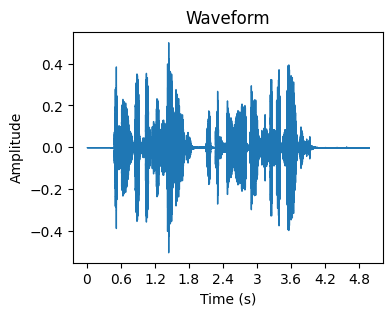

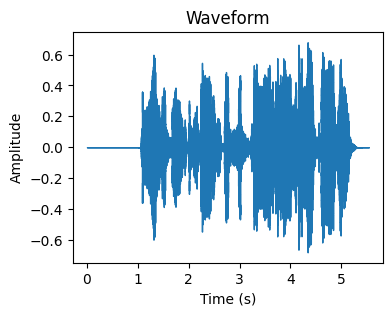

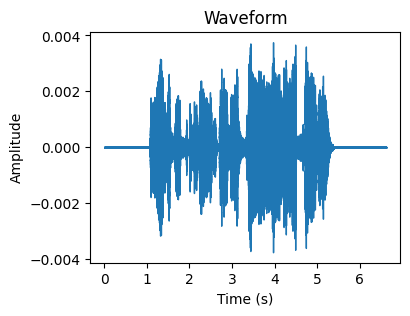

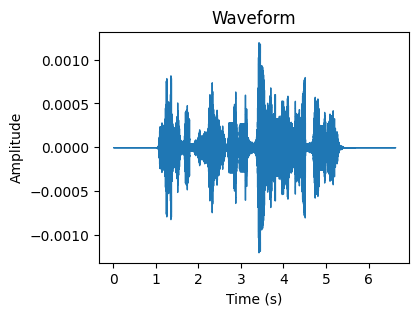

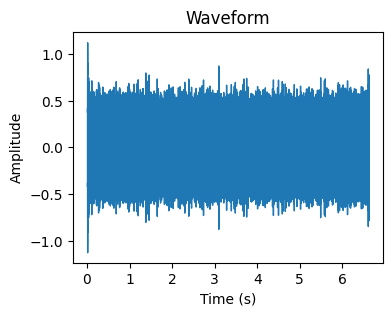

In [ ]:
audio, sr = librosa.load(source_audio, sr=None)
ViewAudio(audio, sr)

audio, sr = librosa.load(target_audio, sr=None)
ViewAudio(audio, sr)

reconstructed_audio = reconstruct_audio_griffinlim(converted1)
ViewAudio(reconstructed_audio, 48000)

reconstructed_audio = reconstruct_audio_istft(converted1)
ViewAudio(reconstructed_audio, 48000)

reconstructed_audio = reconstruct_audio_imfcc(converted2)
ViewAudio(reconstructed_audio, 48000)

Clearly not the best apprach as it the direct mapping also snatches the subtle details of the source audio we need to retain